## Import HarmonicBalance

In [23]:
using HarmonicBalance

## Problem definition

## We are analyzing two coupled parametrons, governed by
$$\ddot{x}_1+\omega_1^2(1-\lambda \cos(2\omega t))x_1+\gamma\dot{x}_1 + \alpha_1 x_1^3 - Jx_2=0\\
\ddot{x}_2+\omega_2^2(1-\lambda \cos(2\omega t))x_2+\gamma\dot{x}_2 + \alpha_2 x_2^3 - Jx_1=0$$

Define problem variables, parameters using the Symbolics.jl @variables macro. Time variables also need to be included

In [24]:
@variables x, y, ω₁, ω₂,ω, γ,λ, t, T, ω, α₁, α₂, J;
@variables x(t), y(t);

Introduce equations to solve via DifferentialEquation input method

In [35]:
natural_equation = [d(d(x, t),t) + ω₁^2*(1-λ*cos(2*ω*t)) * x + γ*d(x,t)  + α₁*x^3 - J*y , 
                    d(d(y,t),t)  + ω₂^2*(1-λ*cos(2*ω*t)) * y + γ*d(y,t)  + α₂*y^3 - J*x] 

dEOM_coupled = HarmonicBalance.DifferentialEquation(natural_equation, [x, y])

dEOM_coupled

System of 2 differential equations
Variables:       x(t), y(t)
Harmonic ansatz: x(t) => ;   y(t) => ;   

α₁*(x(t)^3) + γ*Differential(t)(x(t)) + (ω₁^2)*(1 - λ*cos(2t*ω))*x(t) + Differential(t)(Differential(t)(x(t))) - J*y(t) ~ 0
α₂*(y(t)^3) + γ*Differential(t)(y(t)) + (ω₂^2)*(1 - λ*cos(2t*ω))*y(t) + Differential(t)(Differential(t)(y(t))) - J*x(t) ~ 0


We haven't introduced harmonics yet. let's do that now

In [36]:
HarmonicBalance.add_harmonic!(dEOM_coupled, x, ω) # x will rotate at ω
HarmonicBalance.add_harmonic!(dEOM_coupled, y, ω) # x will rotate at ω
show(dEOM_coupled)

"equations"

OrderedCollections.OrderedDict{Symbolics.Num, Symbolics.Equation} with 2 entries:
  x(t) => α₁*(x(t)^3) + γ*Differential(t)(x(t)) + (ω₁^2)*(1 - λ*cos(2t*ω))*x(t)…
  y(t) => α₂*(y(t)^3) + γ*Differential(t)(y(t)) + (ω₂^2)*(1 - λ*cos(2t*ω))*y(t)…

"harmonics"

OrderedCollections.OrderedDict{Symbolics.Num, Vector{Symbolics.Num}} with 2 entries:
  x(t) => [ω]
  y(t) => [ω]

Let's introduce our ansatz and let Harmonic Balance do the work for us

In [37]:
@time averagedEOM = HarmonicBalance.get_harmonic_equations(dEOM_coupled, slow_time=T, fast_time=t)

  1.025089 seconds (2.92 M allocations: 145.033 MiB, 82.57% compilation time)


A set of 4 harmonic equations
Variables: u1(T), v1(T), u2(T), v2(T)
Parameters: α₁, ω, γ, ω₁, λ, J, α₂, ω₂

Harmonic ansatz: 
x(t) = u1*cos(ωt) + v1*sin(ωt)
y(t) = u2*cos(ωt) + v2*sin(ωt)

Harmonic equations:

(ω₁^2)*u1(T) + γ*Differential(T)(u1(T)) + (3//4)*α₁*(u1(T)^3) + γ*ω*v1(T) + (2//1)*ω*Differential(T)(v1(T)) + (3//4)*α₁*(v1(T)^2)*u1(T) - (ω^2)*u1(T) - J*u2(T) - (1//2)*λ*(ω₁^2)*u1(T) ~ 0

γ*Differential(T)(v1(T)) + (ω₁^2)*v1(T) + (3//4)*α₁*(v1(T)^3) + (1//2)*λ*(ω₁^2)*v1(T) + (3//4)*α₁*(u1(T)^2)*v1(T) - J*v2(T) - (2//1)*ω*Differential(T)(u1(T)) - (ω^2)*v1(T) - γ*ω*u1(T) ~ 0

γ*Differential(T)(u2(T)) + (ω₂^2)*u2(T) + (3//4)*α₂*(u2(T)^3) + γ*ω*v2(T) + (2//1)*ω*Differential(T)(v2(T)) + (3//4)*α₂*(v2(T)^2)*u2(T) - J*u1(T) - (ω^2)*u2(T) - (1//2)*λ*(ω₂^2)*u2(T) ~ 0

γ*Differential(T)(v2(T)) + (ω₂^2)*v2(T) + (3//4)*α₂*(v2(T)^3) + (3//4)*α₂*(u2(T)^2)*v2(T) + (1//2)*λ*(ω₂^2)*v2(T) - J*v1(T) - (ω^2)*v2(T) - (2//1)*ω*Differential(T)(u2(T)) - γ*ω*u2(T) ~ 0


![ChessUrl](https://c.tenor.com/VxSRLg7hSHMAAAAS/carlton-dance.gif "chess")

## Solving for steadystates

Let's solve for the slow-flow amplitudes $u1,u2,v1,v2$ in the steadystate. We will use homotopy continuation for that. In order to talk with the fantastic HomotopyContinuation.jl, we create a Problem instance. 

This holds the steady-state equations, and (optionally) the symbolic Jacobian which is needed for stability / linear response calculations. 

In [28]:
problem_coupled = HarmonicBalance.Problem(averagedEOM)

4 algebraic equations for steady states
Variables: u1, v1, u2, v2
Parameters: α₁, ω, γ, ω₁, λ, J, α₂, ω₂
Symbolic Jacobian: true


Now the actual calculation: we analyze steadystates for varying external drive frequency, while fixing other parameters. We use ParameterRange and ParameterList types for that (basically ordered dictionaries)

In [32]:
fixed_parameters = ParameterList([(ω₁, 1.),( ω₂, 1. ),(γ, 0.001 ),(α₁,  1.),(α₂, 1.),(λ,5E-2),(J,0.05)])
swept_parameters = ParameterRange(ω => LinRange(0.75,1.25, 10))

OrderedCollections.OrderedDict{Symbolics.Num, Vector{Float64}} with 1 entry:
  ω => [0.75, 0.753356, 0.756711, 0.760067, 0.763423, 0.766779, 0.770134, 0.773…

Get steady states!.

With random_warmup=True, we first solve the problem for some synthetic, complex parameters. These allow to filter out many solution paths that end up in $\infty$. After obtained solutions from this general complex system, we track the solutions to the real system for each parameter value.

In [33]:
result = HarmonicBalance.get_steady_states(problem_coupled, swept_parameters, fixed_parameters; random_warmup=true, threading=false)

Solving for 150 parameters... 100%|█████████████████████| Time: 0:00:00
  # parameters solved:  150
  # paths tracked:      12150


A steady state result for 150 parameter points

Solution branches:   81
   of which real:    17
   of which stable:  9

Classes: stable, physical, Hopf, binary_labels


![ChessUrl](https://i.giphy.com/media/StWnlQipuBrz2/giphy.webp "chess")

## Plotting solutions

The most-basic plot we can do is checking the amplitudes $X_i=\sqrt{u_i^2+v_i^2}$. 

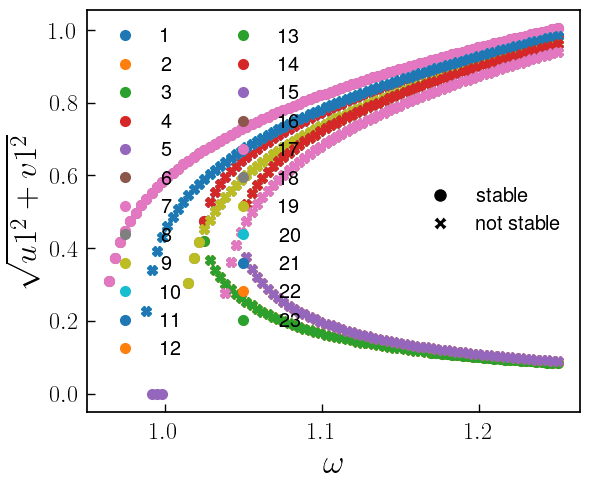

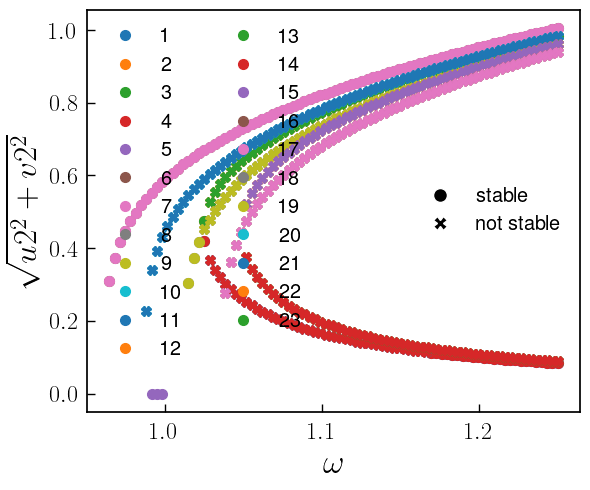

In [34]:
HarmonicBalance.plot_1D_solutions(result, x="ω", y="sqrt(u1^2 + v1^2)", plot_only=["physical"])#,filename="plot_1D");
HarmonicBalance.plot_1D_solutions(result, x="ω", y="sqrt(u2^2 + v2^2)", plot_only=["physical"])#,filename="plot_1D");

A bit confusing. Let's look at one resonator only

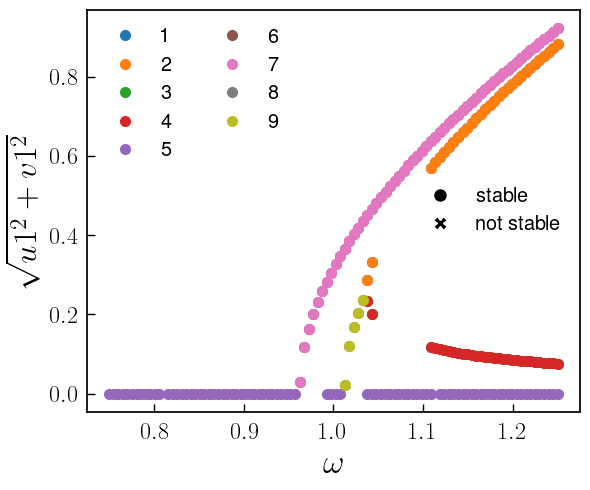

In [13]:
HarmonicBalance.plot_1D_solutions(result, x="ω", y="sqrt(u1^2 + v1^2)", plot_only=["physical","stable"])#,filename="plot_1D");

We can get insight on how the solutions where classified

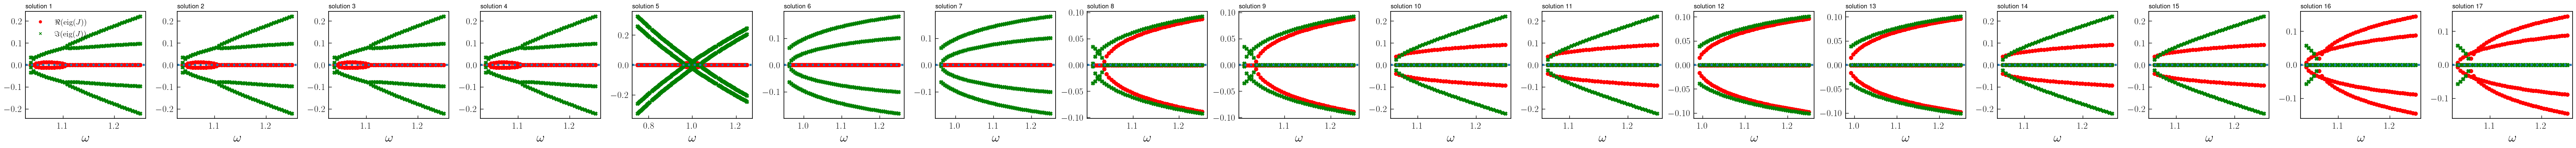

PyObject <matplotlib.legend.Legend object at 0x7f9a407480d0>

In [14]:
HarmonicBalance.plot_1D_jacobian_eigenvalues(result, x="ω", physical=true, stable=false)

You can save the output of the simulation to a .jld2 via save function, and load it via load

In [ ]:
HarmonicBalance.save("1D_sweep",result)
HarmonicBalance.load("1D_sweep.jld2")

## Two-dimensional parametric sweeps

Now let's assume we know relatively well what happens with an isolated parametron. We want to analyse how the frequency response changes because of the coupling to the other parametron. This type of problem is appropriate for a 2D sweep over $(\omega,J)$. 

We can simply add another parameter to ParameterRange and call the same get_steadystates function

It is convenient to sort the solutions for plotting. Nearest neighbor complex solutions are matched if sorting="naive"

In [15]:
fixed_parameters = ParameterList([(ω₁, 1.),( ω₂, 1. ),(γ, 0.001 ),(α₁,  0.01),(α₂, 0.01),(λ,0.2)])
swept_parameters = ParameterRange(ω => LinRange(0.75,1.25, 100),J=>LinRange(0.,0.2,100));

@time result = HarmonicBalance.get_steady_states(problem_coupled, swept_parameters, fixed_parameters; random_warmup=true, threading=false,sorting="naive")

Solving for 10000 parameters... 100%|███████████████████| Time: 0:00:26
  # parameters solved:  10000
  # paths tracked:      250000
 49.654415 seconds (213.94 M allocations: 11.212 GiB, 5.07% gc time, 5.53% compilation time)


A steady state result for 10000 parameter points

Solution branches:   25
   of which real:    25
   of which stable:  11

Classes: stable, physical, Hopf, binary_labels


A simple, useful visualization is to see what's the number of solutions for each point of the 2D grid

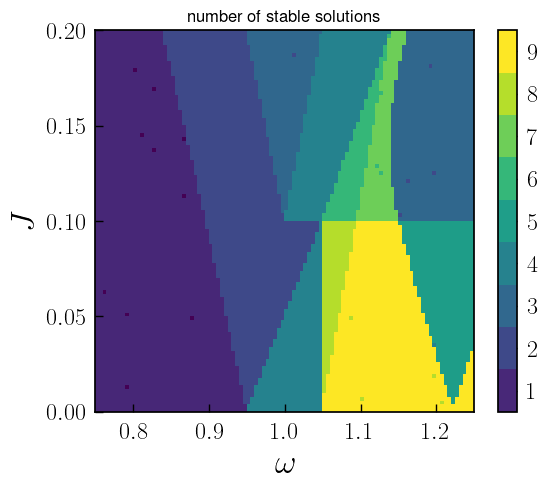

(PyObject <matplotlib.image.AxesImage object at 0x7f9a407bc790>, 9)

In [19]:
HarmonicBalance.plot_2D_phase_diagram(result, stable=true,observable="nsols")

Still, this plot is agnostic to some features of the bifurcation topology. Look at interactive versions

In [20]:
HarmonicBalance.plot_2D_phase_diagram_interactive(result, stable=false, nrows=2, ncols=3,cut_dim="1",cut_type="solutions",observable="nsols")

qt.qpa.drawing: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK


PyObject <matplotlib.colorbar.Colorbar object at 0x7f9a50b125b0>

In [21]:
HarmonicBalance.plot_2D_phase_diagram_interactive(result, stable=false, nrows=2, ncols=2,cut_dim="1",cut_type="transform",observable="nsols",string_f=["sqrt(u1^2 + v1^2)","sqrt(u2^2 + v2^2)"])

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9a41ff4940>

In [22]:
HarmonicBalance.plot_2D_phase_diagram_interactive(result, stable=false, nrows=5, ncols=6,cut_dim="1",cut_type="jacobian_eigenvalues",observable="nsols")

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9a21666fa0>

# Now it's turn turn! . Please pick one of the Exercises below

## Red pill exercise 

* Find the frequency conversion in a parametron with a cubic nonlinearity by analysing the solutions around half the parametric drive $\omega$ and $3\omega$. 

$$\ddot{x}+\omega_1^2(1-\lambda \cos(2\omega t))x+\gamma\dot{x} + \alpha x^3=0$$

* Then include a fifth order nonlinearity and include extra necessary harmonics. 
$$\ddot{x}+\omega_1^2(1-\lambda \cos(2\omega t))x+\gamma\dot{x} + \alpha x^3 + \beta x^5=0$$
How many harmonics do you need to reach convergence?

* Compare the number of solutions as a function of  drive frequency and frequency modulation parameter $\lambda$. Do you find a regime where new solutions appear?.

* Do the solutions converge as you add more tones?

## Blue pill exercise 

* Take three Kerr resonators with three different, non commensurable frequencies. 
* Add driving to one resonator and time-dependent couplings at the frequency difference of these modes, letting some nonzero phase $J_{ij}(t)=J\cos((\omega_i-\omega_j)t + \phi_{ij})$ (assume $\phi_{ij}=-\phi_{ji}$). 

$$\ddot{x}_1+\omega_1^2x_1+\gamma\dot{x}_1 + \alpha_1 x_1^3 - J_{12}(t)x_2 - J_{13}(t)x_3=0\\
\ddot{x}_2+\omega_2^2x_2+\gamma\dot{x}_2 + \alpha_2 x_2^3 - J_{21}(t)x_1 - J_{23}(t)x_3=0\\
\ddot{x}_3+\omega_3^2x_3+\gamma\dot{x}_2 + \alpha_3 x_2^3 - J_{31}(t)x_1- J_{32}(t)x_2=0$$

* Find how solution amplitudes and linear fluctuation dynamics (Jacobian eigenvalues) depend on phases and nonlinearity when resonators form a ring or a chain. For it, analyse solutions vs coupling and phase
* Optional: Is there is any gauge symmetry in the problem? for example invariance with respect to some phase shift: $\phi_{12} \rightarrow \phi_{12} + \delta, \phi_{23}->\phi_{23} - \delta$).  Are symmetries broken by the nonlinear coefficient?